# Selective Inference via outcome Randomisation and Mirror Statistics

In [2]:
using Pkg
Pkg.status()

using GLM
using GLMNet
using Distributions
using Random
using StatsPlots
using Plots

Project selective_inference_project v0.1.0
Status `~/Documents/UiO_Postdoc/Code/git_repositories/SelectiveInference/Project.toml`
  [31c24e10] Distributions v0.25.100
  [38e38edf] GLM v1.8.3
  [8d5ece8b] GLMNet v0.7.2
  [6f49c342] RCall v0.13.17
  [f3b207a7] StatsPlots v0.15.6


In [3]:
include("./utilities/data_generation.jl")
include("./utilities/randomisation_ds.jl")
include("./utilities/mirror_statistic.jl")
include("./utilities/classification_metrics.jl")

Main.classification_metrics

## Simulation on uncorrelated covariates

### Low-dimensional case
30% of coefficients are 0

In [4]:
# Simulate data
n = 100
p = 20

Random.seed!(1345)
data = data_generation.linear_regression_data(
    n=n,
    p=p,
    prop_zero_coef=0.3,
    beta_intercept=1.,
    sigma2=1.
)

(y = [-4.920400998160268, 0.2892218246618592, -0.8675863521515148, -4.14701225274143, 0.3172782482055876, -4.862203171060729, 0.5369323697285354, -0.0020438344689184262, -3.018880545129492, -3.0128711185014376  …  1.643312677889099, 2.5351637610724427, 1.0251137688470302, 2.0374899142874625, -3.838952191812166, -6.035473335613284, -0.3283688343901079, 1.5637885138419085, -0.060772648013488695, 3.0634189377494465], X = [-0.7889360905644462 0.6055271010205558 … 1.0163559203249026 -0.7476933960286056; -0.26472418834451894 -1.295199987753025 … 1.1624552452178003 -0.6110309749250099; … ; -0.4053265656647924 0.016393630866912406 … -0.7134968569002824 1.9262423549083438; 1.0738905395247127 -0.49091758849556794 … 0.280453051438329 -0.10961298046939277], beta_true = [0.0, -1.0, -0.5, 0.5, -0.8, 0.0, -0.8, 0.0, 0.5, 0.8, -1.0, 0.0, 0.5, -0.8, -1.0, -1.0, 0.8, 0.0, 0.0, -0.5])

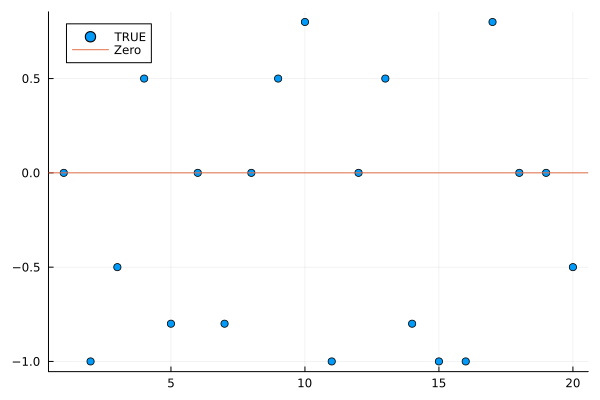

In [5]:
scatter(data.beta_true, label="TRUE")
hline!([0], label="Zero")

Now use data randomisation to do variable selection and inference

In [6]:
# the variance sigma2 is assumed to be know. In this low-dimensional case it can be easily estimated using the LM fit on all data
sigma2 = 1.
u, v = randomisation_ds.randomisation(y=data.y, gamma=1., sigma2=sigma2)

(u = [-3.248680683106154, 1.2245331583804036, -0.34072851321651687, -4.494975001796671, 1.0144473811903127, -6.762351536595219, 3.094048118004655, 0.9138290278669667, -2.318243818510725, -2.2863212317106445  …  1.6114709253311883, 3.556304620546375, 1.4742148831152613, 2.2864247545490097, -4.752007290830211, -5.953411195955829, -0.9044183956173908, 1.570035278863006, 0.8165100539928931, 3.3235062450805346], v = [-6.592121313214382, -0.646089509056685, -1.3944441910865129, -3.7990495036861884, -0.37989088477913746, -2.9620548055262397, -2.020183378547584, -0.9179166968048036, -3.719517271748259, -3.7394210052922308  …  1.6751544304470096, 1.51402290159851, 0.5760126545787991, 1.788555074025915, -2.925897092794121, -6.117535475270739, 0.247680726837175, 1.557541748820811, -0.9380553500198705, 2.8033316304183584])

In [7]:
# Here performa variable selection using Lasso (lambda penalty parameter is CV) and OLS for inference
lasso_coef, lm_coef, lm_pvalues = randomisation_ds.lasso_plus_ols(
    X=data.X,
    u=u,
    v=v,
    add_intercept=true
)

(lasso_coef = [-0.09524323294556088, -0.6996541739827306, -0.46627768531409164, 0.3443380905445127, -0.8444798250651803, -0.30983472950903296, -0.8126289097440437, -0.18156144200444754, 0.34362238819633, 0.6835153638820951, -0.841187706045985, -0.2075243740994013, 0.6130774986501766, -0.7724447115440959, -1.0003919157881798, -1.118785744757432, 0.9957749579014221, -0.27674846306071915, 0.004729845796037856, -0.2200283508724893], lm_coef = [0.10039488908154184, -0.896359832989572, -0.3124569235918313, 0.5590827360915213, -0.9633876270463811, -0.09574338205535006, -0.6878659310685529, -0.08463738967119884, 0.6938988428140668, 0.8812219300394519, -1.138804493657881, -0.2798452866569892, 0.35891431539579394, -0.8049012248405366, -1.1839676206562681, -0.9782963754289855, 0.8659008490861455, -0.050321952009903415, 0.02372630209390011, -0.7086694309833538], lm_pvalues = [0.48359376642679597, 6.386969809263132e-7, 0.07591621122864972, 0.0002812551223289743, 8.958697398479724e-9, 0.549940634931

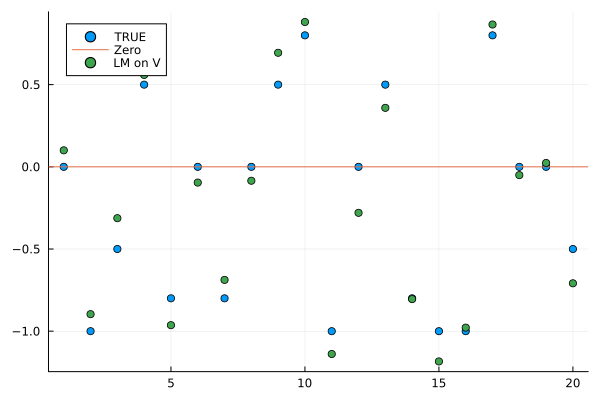

In [8]:
scatter!(lm_coef, label="LM on V")

Now check FDR using adjusted pvalues with BH procedure

In [9]:
adjusted_pvalues = classification_metrics.bh_correction(p_values=lm_pvalues, fdr_level=0.1)

data_rand_fdr = classification_metrics.false_discovery_rate(
    true_coef=data.beta_true,
    estimate_coef=adjusted_pvalues[:, 3]
)
print("FDR from data Randomisation is $data_rand_fdr")

FDR from data Randomisation is 0.0

In [10]:
data_rand_fdr = classification_metrics.false_discovery_rate(
    true_coef=data.beta_true,
    estimate_coef=lm_pvalues .<= 0.05
)

0.0

Add Mirror Statistic on top of data randomisation to check for any improvement on the FDR

In [11]:
ms_coef = mirror_statistic.mirror_stat(lm_coef, lasso_coef)
# get optimal threshold for the mirror statistics for the given FDR desired level
optimal_t = mirror_statistic.optimal_threshold(mirror_coef=ms_coef, fdr_q = 0.1)

0.0

In [12]:
ms_fdr = classification_metrics.false_discovery_rate(
    true_coef=data.beta_true,
    estimate_coef=ms_coef .> optimal_t
)
print("FDR from Randomisation + Mirror Stat is $ms_fdr")

FDR from Randomisation + Mirror Stat is 0.2631578947368421

In [13]:
hcat(data.beta_true, adjusted_pvalues[:, 3], ms_coef .> optimal_t)

20×3 Matrix{Float64}:
  0.0  0.0  0.0
 -1.0  1.0  1.0
 -0.5  0.0  1.0
  0.5  1.0  1.0
 -0.8  1.0  1.0
  0.0  0.0  1.0
 -0.8  1.0  1.0
  0.0  0.0  1.0
  0.5  1.0  1.0
  0.8  1.0  1.0
 -1.0  1.0  1.0
  0.0  0.0  1.0
  0.5  1.0  1.0
 -0.8  1.0  1.0
 -1.0  1.0  1.0
 -1.0  1.0  1.0
  0.8  1.0  1.0
  0.0  0.0  1.0
  0.0  0.0  1.0
 -0.5  1.0  1.0

### High-dimensional scenario

In [14]:
# Simulate data
n = 100
p = 200
# the proportion of zero coefficients has to be higher than 0.5

Random.seed!(1345)
data = data_generation.linear_regression_data(
    n=n,
    p=p,
    prop_zero_coef=0.7,
    beta_intercept=1.,
    sigma2=1.
)

(y = [4.593627602920667, 6.608320200140876, -12.156641356034458, 0.9244682217654114, -1.3693679737732105, 6.682426038939494, 3.6436266798245063, -5.247848576658724, -8.63503904028364, 3.978988874081552  …  8.764074208228621, 11.08221988000136, 5.994994329322659, 2.068119692435367, -7.401251025046289, -5.448035096371264, -4.61253309021509, 1.2981236599607853, -3.2048501633967383, -6.396488684616786], X = [0.24898080739663456 -0.9239478346407074 … -0.6877661026982355 1.0286179735533756; 0.1846030772413031 0.42511205188605716 … 1.8625385222887076 -0.18681018411552805; … ; -1.3072873125750644 -0.23112332976524586 … 0.720263454548523 2.3286871420216597; -0.9276550561162654 -0.319119047569456 … 0.37162172995027765 1.1849808419323373], beta_true = [-0.5, 0.0, -0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, -0.8, 0.0, 0.0, 0.0, 0.0, -0.8, 0.0, 0.0, 0.0])

In [15]:
# the variance sigma2 is assumed to be know. In this low-dimensional case it can be easily estimated using the LM fit on all data
sigma2 = 1.
u, v = randomisation_ds.randomisation(y=data.y, gamma=1., sigma2=sigma2)

# Here performa variable selection using Lasso (lambda penalty parameter is CV) and OLS for inference
lasso_coef, lm_coef, lm_pvalues = randomisation_ds.lasso_plus_ols(
    X=data.X,
    u=u,
    v=v,
    add_intercept=true
)

(lasso_coef = [-0.3366697464674065, 0.0, 0.0, 0.0, 0.15469089876399064, -0.06287325050305567, 0.0, 0.0, 0.0, 0.0  …  -0.05871704005584464, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], lm_coef = [-0.4695939490882988, 0.0, 0.0, 0.0, 0.3599210549456465, -0.10378718436935222, 0.0, 0.0, 0.0, 0.0  …  -0.6802952898209116, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], lm_pvalues = [0.20177807068454667, 1.0, 1.0, 1.0, 0.3431195690922183, 0.8017462448707648, 1.0, 1.0, 1.0, 1.0  …  0.0698135260013722, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

In [18]:
adjusted_pvalues = classification_metrics.bh_correction(p_values=lm_pvalues, fdr_level=0.1)

data_rand_fdr = classification_metrics.false_discovery_rate(
    true_coef=data.beta_true,
    estimate_coef=adjusted_pvalues[:, 3]
)
print("FDR from data Randomisation is $data_rand_fdr")

FDR from data Randomisation is 0.0

In [19]:
data_rand_fdr = classification_metrics.false_discovery_rate(
    true_coef=data.beta_true,
    estimate_coef=lm_pvalues .<= 0.05
)

0.3333333333333333

Mirror statistics

In [20]:
ms_coef = mirror_statistic.mirror_stat(lm_coef, lasso_coef)
# get optimal threshold for the mirror statistics for the given FDR desired level
optimal_t = mirror_statistic.optimal_threshold(mirror_coef=ms_coef, fdr_q = 0.1)

0.0

In [22]:
ms_fdr = classification_metrics.false_discovery_rate(
    true_coef=data.beta_true,
    estimate_coef=ms_coef .> -optimal_t
)
print("FDR from Randomisation + Mirror Stat is $ms_fdr")

FDR from Randomisation + Mirror Stat is 0.43137254901960786